In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
import os
import zipfile
import requests
import pandas as pd

from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from yellowbrick.cluster import InterclusterDistance

In [3]:
URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00498/incident_event_log.zip"
FILE_PATH = "incidents.zip"
DIRECTORY_PATH = "incidents"

def fetch_data(url, fname):
    """
    Helper method to retreive the ML Repository dataset.
    """
    response = requests.get(url)
    outpath  = os.path.abspath(fname)
    with open(outpath, "wb") as f:
        f.write(response.content)
    
    return outpath

# Fetch the data if required
DATA = fetch_data(URL, FILE_PATH)

# Unzip the data
with zipfile.ZipFile(FILE_PATH, "r") as zip_ref:
    zip_ref.extractall(DIRECTORY_PATH)

In [4]:
incidents_df = pd.read_csv(
    os.path.join(DIRECTORY_PATH, "incident_event_log.csv"),
    nrows=10000 # just taking the first 10k rows for efficiency
)

In [5]:
len(incidents_df)

10000

In [6]:
incidents_df.head()

,number,incident_state,active,reassignment_count,reopen_count,sys_mod_count,made_sla,caller_id,opened_by,opened_at,...,u_priority_confirmation,notify,problem_id,rfc,vendor,caused_by,closed_code,resolved_by,resolved_at,closed_at
0,INC0000045,New,True,0,0,0,True,Caller 2403,Opened by 8,29/2/2016 01:16,...,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
1,INC0000045,Resolved,True,0,0,2,True,Caller 2403,Opened by 8,29/2/2016 01:16,...,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
2,INC0000045,Resolved,True,0,0,3,True,Caller 2403,Opened by 8,29/2/2016 01:16,...,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
3,INC0000045,Closed,False,0,0,4,True,Caller 2403,Opened by 8,29/2/2016 01:16,...,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
4,INC0000047,New,True,0,0,0,True,Caller 2403,Opened by 397,29/2/2016 04:40,...,False,Do Not Notify,?,?,?,?,code 5,Resolved by 81,1/3/2016 09:52,6/3/2016 10:00


In [7]:
# drop any NaNs
incidents_df = incidents_df.dropna()

# encode the categorical features
encoder = OneHotEncoder()
X = encoder.fit_transform(incidents_df[["incident_state", "active"]].values)

In [8]:
model = KMeans(4)

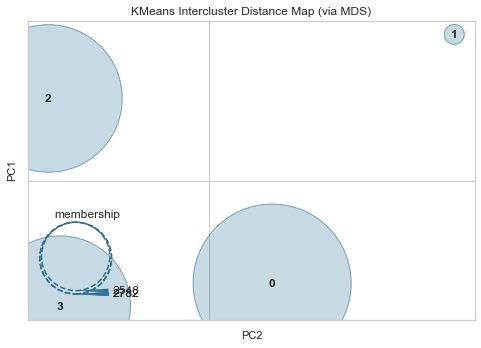

In [9]:
visualizer = InterclusterDistance(model)

visualizer.fit(X.toarray())
visualizer.show()

In [10]:
# create a new column in our dataframe with the cluster assignment
incidents_df["cluster"] = pd.Series(
    model.labels_, index=incidents_df.index
)

In [11]:
# pick one cluster and dive in
second_cluster = incidents_df.loc[incidents_df["cluster"] == 2]
second_cluster.head()

,number,incident_state,active,reassignment_count,reopen_count,sys_mod_count,made_sla,caller_id,opened_by,opened_at,...,notify,problem_id,rfc,vendor,caused_by,closed_code,resolved_by,resolved_at,closed_at,cluster
0,INC0000045,New,True,0,0,0,True,Caller 2403,Opened by 8,29/2/2016 01:16,...,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00,2
4,INC0000047,New,True,0,0,0,True,Caller 2403,Opened by 397,29/2/2016 04:40,...,Do Not Notify,?,?,?,?,code 5,Resolved by 81,1/3/2016 09:52,6/3/2016 10:00,2
13,INC0000057,New,True,0,0,0,True,Caller 4416,Opened by 8,29/2/2016 06:10,...,Do Not Notify,?,?,?,?,code 10,Resolved by 5,1/3/2016 02:55,6/3/2016 03:00,2
14,INC0000057,New,True,0,0,1,True,Caller 4416,Opened by 8,29/2/2016 06:10,...,Do Not Notify,?,?,?,?,code 10,Resolved by 5,1/3/2016 02:55,6/3/2016 03:00,2
15,INC0000057,New,True,0,0,2,True,Caller 4416,Opened by 8,29/2/2016 06:10,...,Do Not Notify,Problem ID 2,?,?,?,code 10,Resolved by 5,1/3/2016 02:55,6/3/2016 03:00,2
